In [3]:
import yaml
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

config_path = Path("../config.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

csv_path = config["data"]["clean_data_csv"]["clean_data"]
csv_full_path = config_path.parent / csv_path

df = pd.read_csv(csv_full_path)
print("✅ Original shape:", df.shape)


✅ Original shape: (7906, 46)


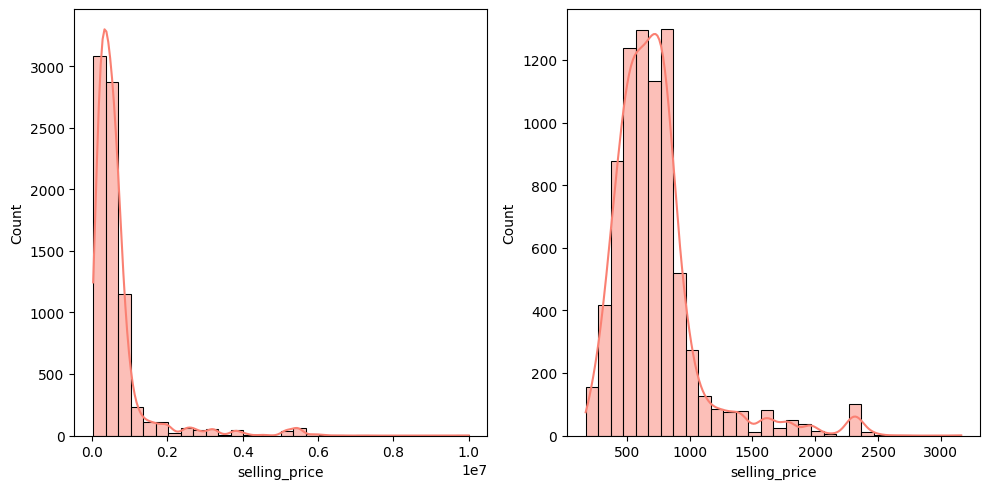

In [4]:
import numpy as np

fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.histplot(df['selling_price'], kde=True, bins=30, color="salmon", ax=axes[0])
sns.histplot(np.sqrt(df['selling_price']), kde=True, bins=30, color="salmon", ax=axes[1])
plt.tight_layout()
plt.show()

In [5]:
# Power Transformation
#To address strong skewness in numerical features (e.g., `selling_price`, `engine`, `max_power`, `torque`),  
#we applied a **PowerTransformer**.  
#This technique symmetrizes the data distribution and reduces the impact of extreme values without losing information.  
#It helps the model learn more stable patterns, especially for regression tasks.

from sklearn.preprocessing import PowerTransformer

num_cols = ['selling_price','km_driven','engine','max_power','torque','mileage']
pt = PowerTransformer()
df[num_cols] = pt.fit_transform(df[num_cols])

print("✅ PowerTransformer applied successfully")


✅ PowerTransformer applied successfully


/Users/priyanka/Documents/IronHack/Project/Project5/Project-ML/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


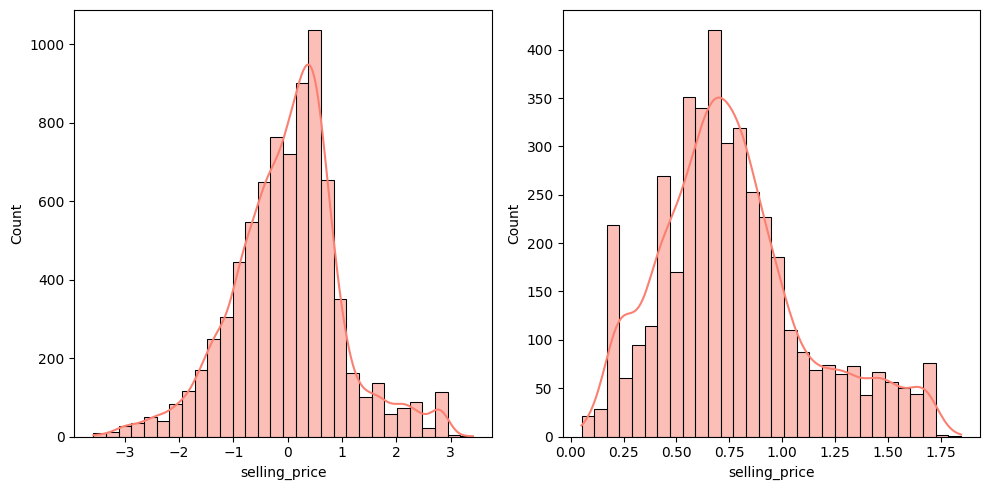

In [6]:
import numpy as np

fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.histplot(df['selling_price'], kde=True, bins=30, color="salmon", ax=axes[0])
sns.histplot(np.sqrt(df['selling_price']), kde=True, bins=30, color="salmon", ax=axes[1])
plt.tight_layout()
plt.show()

In [7]:
#Removing extreme outliers

Q1 = df['selling_price'].quantile(0.25)
Q3 = df['selling_price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

df = df[(df['selling_price'] >= lower_bound) & (df['selling_price'] <= upper_bound)]
print("✅ Shape after removing extreme outliers from target:", df.shape)


✅ Shape after removing extreme outliers from target: (7566, 46)


In [8]:
# === REAPPLY POWERTRANSFORMER AND MINMAXSCALER AFTER OUTLIER REMOVAL ===
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

num_cols = ['selling_price', 'km_driven', 'engine', 'max_power', 'torque', 'mileage']
cat_cols = [col for col in df.columns if col not in num_cols]

# Reapply PowerTransformer now that extreme outliers are removed
pt = PowerTransformer()
df[num_cols] = pt.fit_transform(df[num_cols])

# Scale only the numeric columns
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("✅ PowerTransformer + MinMaxScaler applied successfully after outlier removal")
print("Shape:", df.shape)


✅ PowerTransformer + MinMaxScaler applied successfully after outlier removal
Shape: (7566, 46)


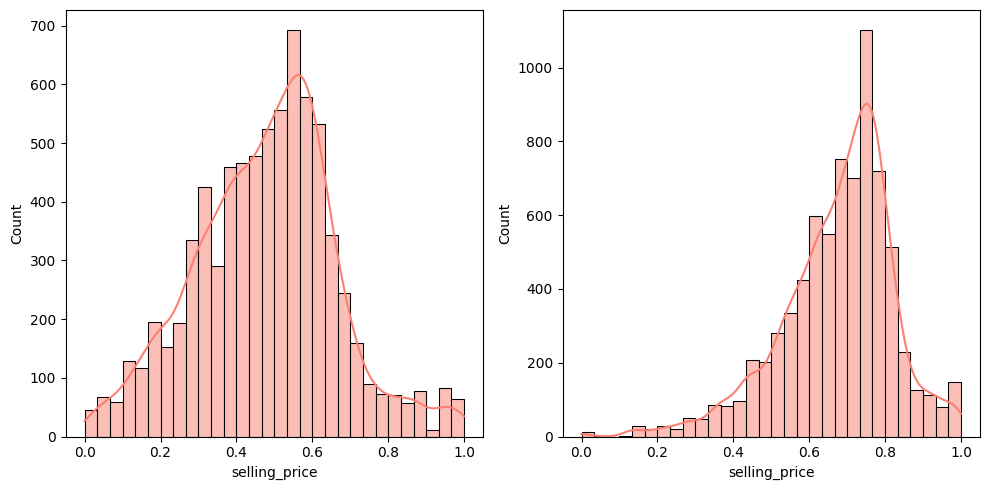

In [9]:
import numpy as np

fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.histplot(df['selling_price'], kde=True, bins=30, color="salmon", ax=axes[0])
sns.histplot(np.sqrt(df['selling_price']), kde=True, bins=30, color="salmon", ax=axes[1])
plt.tight_layout()
plt.show()

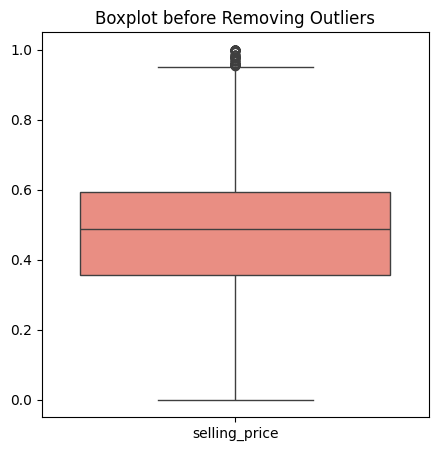

Shape before removing outliers: (7566, 46)
Shape after removing outliers: (7472, 46)


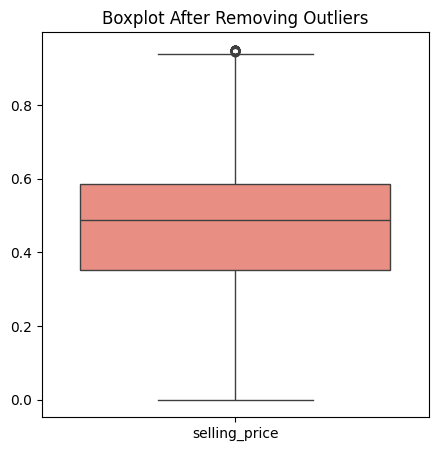

In [11]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df[['selling_price']], color="salmon")  # single box color
plt.title("Boxplot before Removing Outliers")
plt.show()

numeric_cols = ['selling_price']
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df
print("Shape before removing outliers:", df.shape)
for col in numeric_cols:
    df = remove_outliers_iqr(df, col)
print("Shape after removing outliers:", df.shape)
# Optional: visualize after cleaning
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
sns.boxplot(data=df[numeric_cols], color="salmon")
plt.title("Boxplot After Removing Outliers")
plt.show()

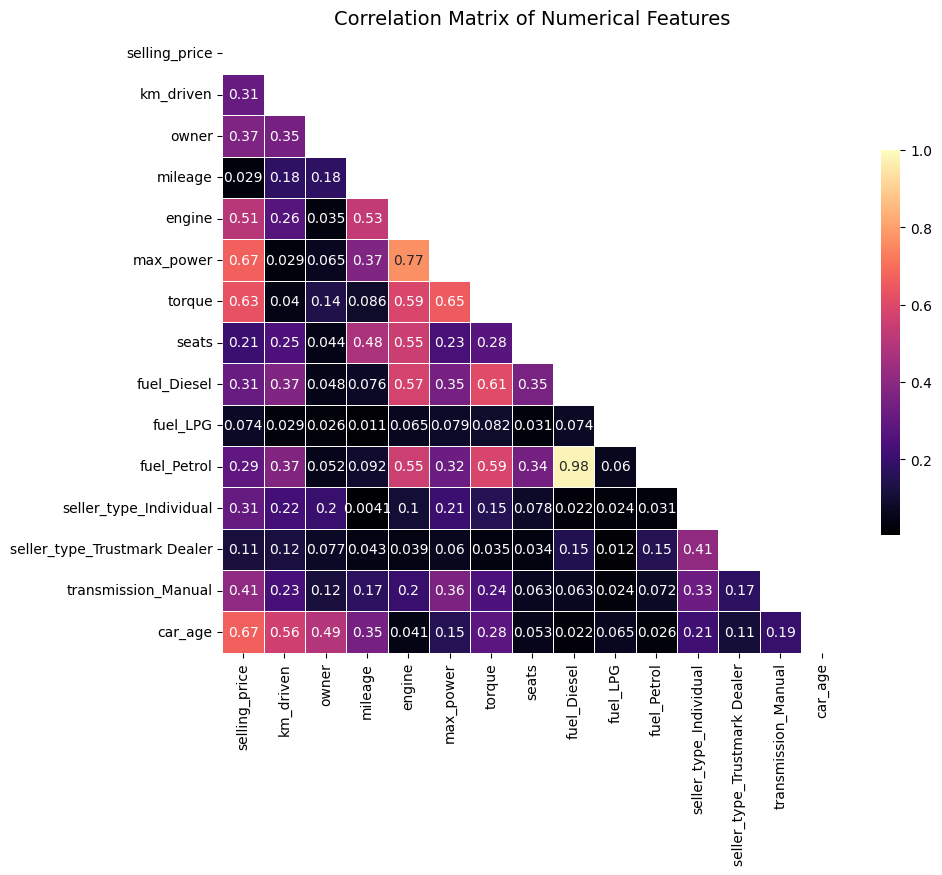

In [7]:
# === FEATURE CORRELATION ANALYSIS (FINAL CLEAN DATASET) ===

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Drop brand dummy columns to simplify visualization
df_corr = df.copy()
df_corr = df_corr.drop(columns=[
    'brand_Ashok','brand_Audi','brand_BMW','brand_Chevrolet','brand_Daewoo',
    'brand_Datsun','brand_Fiat','brand_Force','brand_Ford','brand_Honda',
    'brand_Hyundai','brand_Isuzu','brand_Jaguar','brand_Jeep','brand_Kia',
    'brand_Land','brand_Lexus','brand_MG','brand_Mahindra','brand_Maruti',
    'brand_Mercedes-Benz','brand_Mitsubishi','brand_Nissan','brand_Opel',
    'brand_Peugeot','brand_Renault','brand_Skoda','brand_Tata','brand_Toyota',
    'brand_Volkswagen','brand_Volvo'
])

# Calculate the absolute correlation matrix
corr = np.abs(df_corr.corr())

# Create a mask for the upper triangle (to avoid duplicate values)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(corr, mask=mask, cmap='magma', vmax=1, square=True, linewidths=.5,
            annot=True, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Numerical Features', fontsize=14)
plt.show()


### Correlation Analysis and Feature Selection

After analyzing the correlation matrix of all numerical features, we observed moderate relationships between some variables 
(e.g., `max_power` and `engine`), but no correlations exceeded a critical threshold (0.85). 

Therefore, we decided **not to drop any features** at this stage, since all of them may still contribute useful information 
to the predictive models. Tree-based algorithms (e.g., Random Forest, Gradient Boosting) are also robust to multicollinearity, 
which supports this decision.

In [9]:
df.to_csv("../data/clean_data_csv/clean_data_v3_irma.csv", index=False)
print("Saved final cleaned and transformed dataset as clean_data_v3_irma.csv")



Saved final cleaned and transformed dataset as clean_data_v3_irma.csv


,selling_price,km_driven,owner,mileage,engine,max_power,torque,seats,fuel_Diesel,fuel_LPG,...,brand_Nissan,brand_Opel,brand_Peugeot,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo,car_age
0,0.488000,0.341286,0.0,0.655999,0.535379,0.467401,0.418743,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
1,0.435603,0.316742,1.0,0.582041,0.640637,0.627256,0.498515,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11
2,0.206186,0.336228,2.0,0.472299,0.640276,0.493676,0.040177,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
3,0.302060,0.323773,0.0,0.642808,0.601599,0.562794,0.081435,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
4,0.152797,0.316742,0.0,0.422550,0.559201,0.553238,0.034175,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7901,0.396728,0.306251,0.0,0.497497,0.509353,0.523220,0.299113,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
7902,0.163157,0.315717,3.0,0.444206,0.638829,0.654305,0.087362,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
7903,0.444146,0.316742,0.0,0.522898,0.535379,0.466720,0.418743,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
7904,0.370332,0.173606,0.0,0.661619,0.601599,0.439165,0.343422,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12
